# Feature Selection

Feature selection is another set of techniques to take advantage of to either boost a model's performance, improve accuracy, or reduce the dimensionality of a high dimensionality data set.

We have already seen a few of these techniques like PCA or regularization. Scikit-learn provides a few conveniences around these techniques and others for selecting features that matter in [`sklearn.feature_selection`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection).

## Removing Features with Low Variance

By default, `VarianceThreshold` removes all features that do not have any variance within a sample. This is settable.

In [1]:
from sklearn.feature_selection import VarianceThreshold

X = [
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0],
    [0, 1, 1],
    [0, 1, 0],
    [0, 1, 1]
]

minimum_variance = .8 * (1 - .8)
sel = VarianceThreshold(threshold=minimum_variance)
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

## Univariate Feature Selection 

There are a few Transformers that select featured based on univariate statistical test.

The first is [`SelectKBest`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest), which removes all but the $k$ highest scoring features. This is an implementation of what Jeff Leek light-heartedly calls the [Leekasso](https://simplystatistics.org/2012/02/23/prediction-the-lasso-vs-just-using-the-top-10/), if and only if k is 10, in the case of $n << p$. In some simulations he's put on his blog over the years, this estimator outperforms the lasso.

[`SelectPercentile`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile) is a similar function that selects based on percentiles vs. $k$.

There are a number of approaches that select features while controlling for the vagaries of multiple comparisons. You can conceptualize the multiple comparisons problem like this. If we were to test 10,000 features with a fixed p-value of .05, then just *by chance*, we'd expect 500 features to be significant. These methods adjust for multiple comparisons to avoid making Type I error of rejecting the null when it's true (i.e., a false hit). These are 

* [`SelectFpr`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFpr.html#sklearn.feature_selection.SelectFpr). This selects features based on a p-value threshold adjusted by controlling for the false positive rate (FPR). This controls for probability of rejecting the null when its true. This is mathematically equivalent to the Type I error rate.
* [`SelectFdr`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFdr.html#sklearn.feature_selection.SelectFdr). This selected features based on a p-value adjusted to control for the false discovery rate (FDR). The False Discovery rate is the expected proportion of Type I errors among the rejected hypotheses.
* [`SelectFwe`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFwe.html#sklearn.feature_selection.SelectFwe). This selects features based on a p-value threshold controlling for the family-wise error rate. This controls for the probability of at least one Type I error. Useful when you want to guard against making any false positives.

## Recursive Feature Selection 

This is a technique by which features are eliminated in parametric models based on their weight. Those below a certain threshold are eliminated. The procedues is then performed again and again until the desired number of features is found.

This is available in [`sklearn.feature_selection.RFE`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE).

In this example, you can see that the boundaries of the image do little to predict the target.

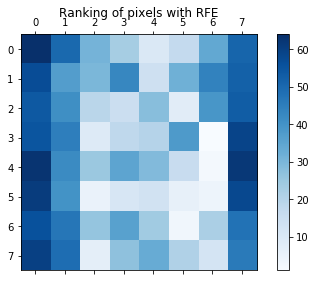

In [2]:
%matplotlib inline

from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
fig, ax = plt.subplots()

mat = ax.matshow(ranking, cmap=plt.cm.Blues)
fig.colorbar(mat)
ax.set_title("Ranking of pixels with RFE")
fig.tight_layout()

## SelectFromModel 

[`SelectFromModel`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel) is a meta-transformer that will select features from any estimator that has a `coef_` attribute or a `feature_importances_` attribute.  

### L1-based Feature Selection 

This works naturally with the lasso by selecting out by default features whose coefficients are zero.

In [3]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
iris = load_iris()
X, y = iris.data, iris.target
X.shape

(150, 4)

In [4]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

(150, 3)

### Randomized Sparse Models via Stability Selection

The lasso is fantastic. That said, the lasso has certain known limitations. Given a group of highly correlated variables, the lasso will select one at random. Even under less strong correlation the conditions under which "good" variables are selected can leave some things to be desired.

Scikit-learn provides a method known as stability selection in the literature to attempt get around these issues. In this method a subsample of the data is fit and a random subset of the features have their penalty scaled.

For some subset of the data $I$ this modified lasso is

$$\hat{\beta}_I=\arg\underset{w}{\min}\frac{1}{n_I}\sum_{i\in I}(y_i - x_i^\prime \beta)^2 + \alpha\sum_{i=1}^p \frac{|\beta_j|}{s_j}$$

where $s_j \in {s, 1}$ are independent draws from Bernoulli trials and $s \in (0, 1)$ is a scaling factor. Across a number of runs, you can count the number of times features were selected.

This is implemented in [`sklearn.linear_model.RandomizedLasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RandomizedLasso.html#sklearn.linear_model.RandomizedLasso) and [`sklearn.linear_model.RandomizedLogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RandomizedLogisticRegression.html#sklearn.linear_model.RandomizedLogisticRegression).

### Tree-Based Feature Selection 

All of the tree-based estimators can be used to compute feature importances. When paired with `SelectFromModel`, you can use the tree-based models to eliminate features as well. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=15,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

In [6]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)

importances = forest.feature_importances_

In [7]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

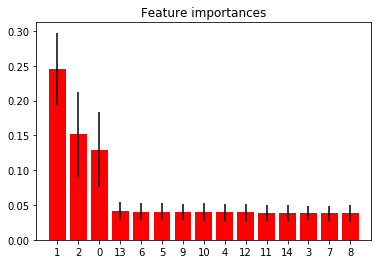

In [8]:
fig, ax = plt.subplots()
ax.set_title("Feature importances")
ax.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
ax.set_xticks(range(X.shape[1]))
ax.set_xticklabels(indices)
ax.set_xlim([-1, X.shape[1]]);